In [ ]:
%reload_ext autoreload
%autoreload 2

import sys
import os

cwd = os.getcwd()
parent_dir = os.path.abspath(os.path.join(cwd, '..'))
sys.path.append(parent_dir)

import c2qa
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumRegister, ClassicalRegister
from qutip import *
from qiskit.circuit.library import UnitaryGate
from custom_gates import shors,state_generation,state_transfer
from qiskit.visualization import plot_histogram
from scipy.stats.contingency import margins
from qiskit.quantum_info import partial_trace

## Basic States

In [2]:
cutoff = 2**6
qmr1 = c2qa.QumodeRegister(num_qumodes=1, num_qubits_per_qumode=int(np.ceil(np.log2(cutoff))),name = 'qumode')
qbr = QuantumRegister(1)
cr = ClassicalRegister(1)

circuit = c2qa.CVCircuit(qmr1, qbr, cr)
circuit.cv_initialize(0, qmr1[0])

state, result, _ = c2qa.util.simulate(circuit,shots = 1024)

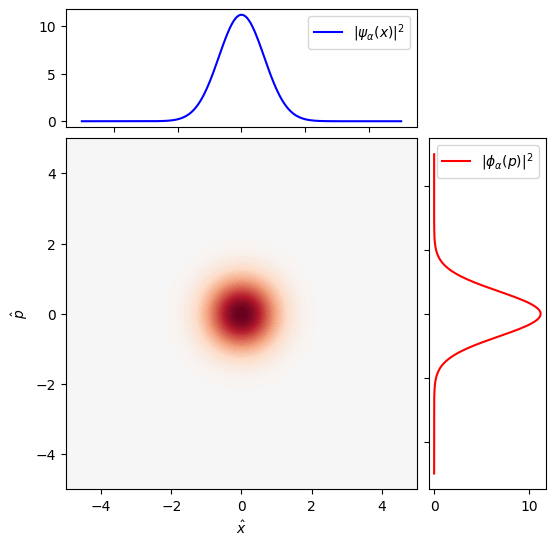

In [3]:
#This cell is mostly plotting
w = c2qa.wigner.wigner(state, axes_max= 5, axes_min= -5, axes_steps = 200)
x_dist, y_dist = margins(w.T)

fig = plt.figure(figsize=(6,6))
gs = fig.add_gridspec(2, 2,  width_ratios=(3, 1), height_ratios=(1, 3),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
ax = fig.add_subplot(gs[1,0])
ax_x = fig.add_subplot(gs[0,0])
ax_y = fig.add_subplot(gs[1,1])

absmax = max(np.max(w), np.abs(np.min(w)))
color_levels = np.linspace(-absmax, absmax, 100)

#Plot the wigner function of the vaccum state in the main panel with a colormap
xaxis = np.linspace(-5, 5, 200)
yaxis = np.linspace(-5, 5, 200)
cont = ax.contourf(xaxis, yaxis, w, color_levels, cmap = "RdBu_r")

#plot the distributions against the (normalized) marginals of the wigner function
ax_x.plot(xaxis, x_dist,  label = r"$|\psi_\alpha(x)|^2$", c= "b")

ax_y.plot(y_dist.T, yaxis, label = r"$|\phi_\alpha(p)|^2$", c = "r")

ax.set(xlabel=r"$\hat x$", ylabel=r"$\hat p$")
ax_x.legend()
ax_y.legend()
ax_x.set_xticklabels([]);
ax_y.set_yticklabels([]);

## State Transfer

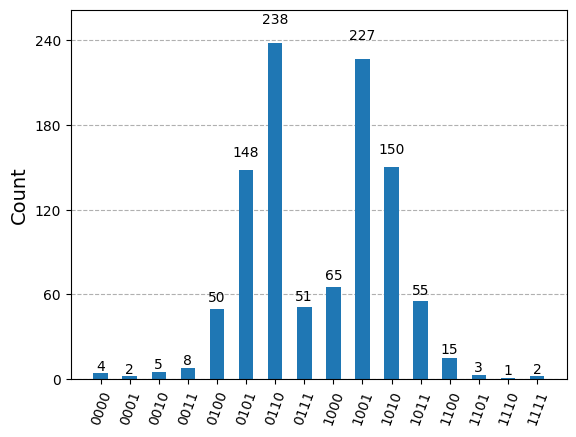

In [ ]:
# dv_to_cv = state_transfer.dv2cv_st_non_abelian(0.29,4,cutoff)
# cv_to_dv = dv_to_cv.dag()

cv_to_dv = np.load("Ust1.npy")  ## This is to directly apply the combined unitary



def apply_basis_transformation(circuit, qbr1):
    num_qubits = len(qbr1)
    for i in range(num_qubits):
        circuit.h(qbr1[i])
        if i == num_qubits - 1:  # MSB
            circuit.x(qbr1[i])
            circuit.z(qbr1[i])
        elif i == 0:  # LSB
            circuit.z(qbr1[i])
        else:  # Middle qubits
            circuit.x(qbr1[i])
            
from custom_gates import state_transfer

# Initialize the circuit
qbm = 4
lmbda = 0.29
cutoff = 2**6
qmr = c2qa.QumodeRegister(1, num_qubits_per_qumode=6)
qbr1 = QuantumRegister(4)
cr1 = ClassicalRegister(4)
circuit = c2qa.CVCircuit(qmr, qbr1, cr1)

# Initialize the CV qumode
circuit.cv_initialize(1, qmr[0])  # initializing qumode in Fock State 1
circuit.barrier(label='')

# Add the CV-to-DV transfer gate
for j in range(1,qbm+1):
        V_j = state_transfer.Vj(lmbda,j,4,cutoff)
        gate1 = UnitaryGate(V_j.full(), label=f'V{j}')
        circuit.append(gate1, qmr[:] + qbr1[:])  # adding custom gate : Conditional displacement in p direction
        
        W_j = state_transfer.Wj(lmbda,j,4,cutoff)
        gate1 = UnitaryGate(W_j.full(), label=f'W{j}')
        circuit.append(gate1, qmr[:] + qbr1[:])  # adding custom gate : Conditional displacement in x direction


circuit.barrier()

# Apply basis transformation
apply_basis_transformation(circuit, qbr1)

circuit.barrier()

# Simulate and measure
for i in range(len(qbr1)):
    circuit.measure(qbr1[i], cr1[-(i + 1)])

state1, result, _ = c2qa.util.simulate(circuit, shots=1024)
plot_histogram(result.get_counts())

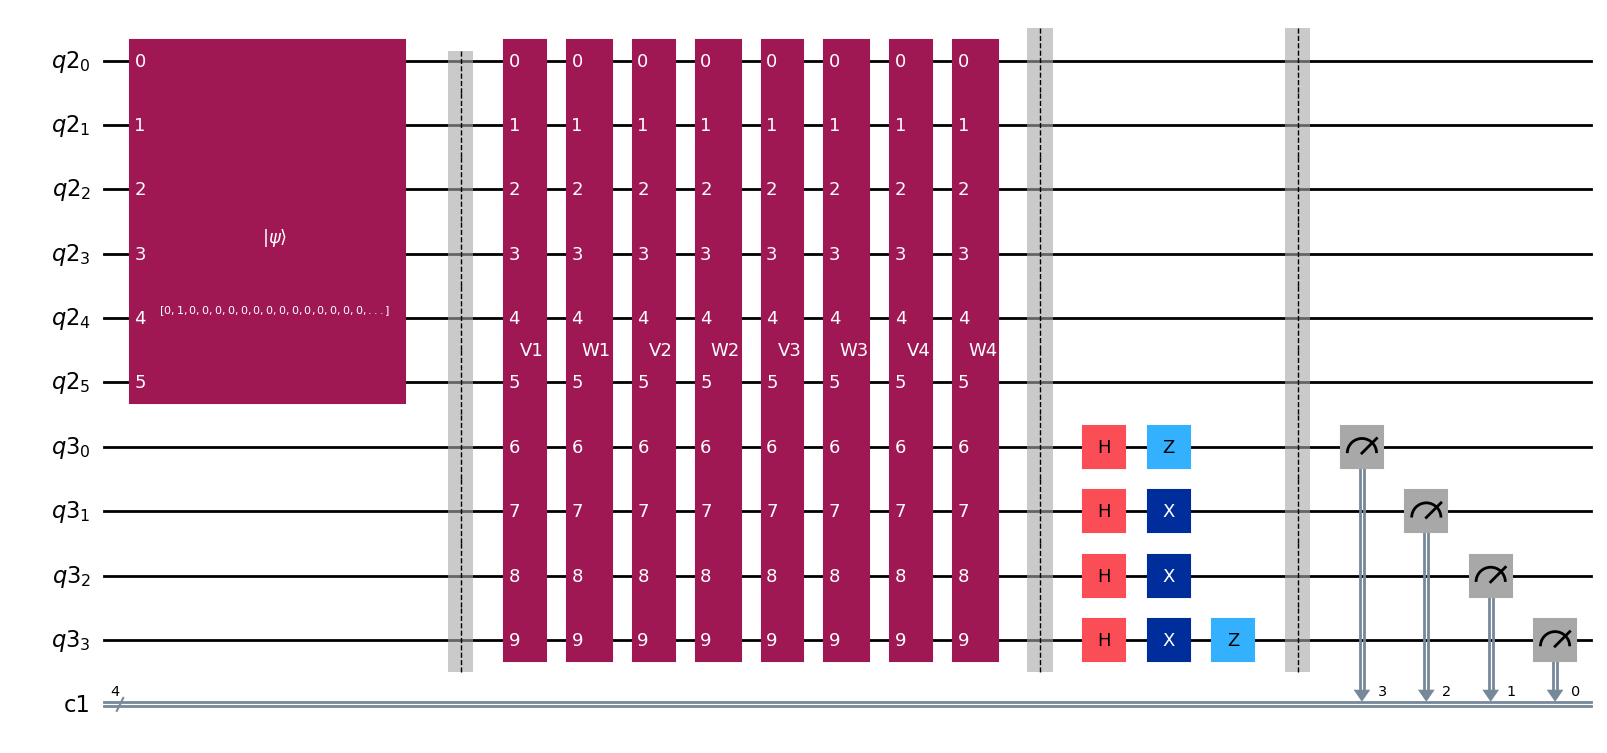

In [6]:
circuit.draw('mpl')

## CAT State

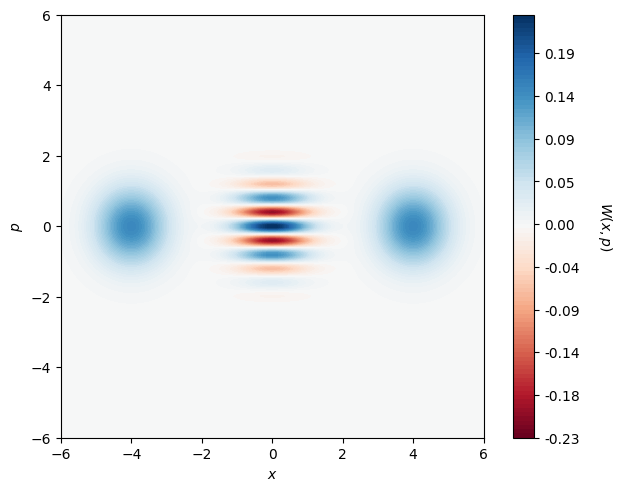

In [78]:
Nmodes=1
Nqubits = 1 

qmr = c2qa.QumodeRegister(num_qumodes=1, num_qubits_per_qumode=6,name='qmode')
qbr = QuantumRegister(1,name = 'qbit')
cbr = ClassicalRegister(1)
circuit = c2qa.CVCircuit(qmr, qbr, cbr)

cutoff = 2**6
alpha = 4.0/np.sqrt(2)

cdReal = state_generation.CD_real(cutoff,-alpha)
CD_real_gate = UnitaryGate(cdReal.full(), label='CD')
circuit.append(CD_real_gate, qmr[:] + qbr[:])  ## add custom gate :- displacement on qumode position conditioned on qubit state

cdImaginary = state_generation.CD_imaginary(cutoff,-alpha)
CD_imag_gate = UnitaryGate(cdImaginary.full(), label='Disentangle')
circuit.append(CD_imag_gate, qmr[:] + qbr[:])  ## add custom gate :- rotation on qubit state conditioned on qumode position


stateop, result, _ = c2qa.util.simulate(circuit,shots = 1024)

fig = c2qa.wigner.plot_wigner(circuit, stateop)


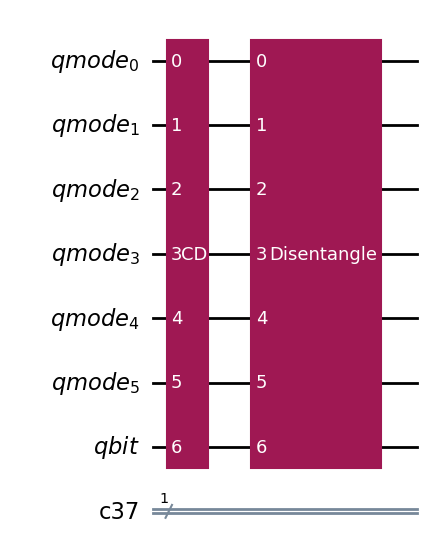

In [ ]:
# circuit.draw('mpl')

## GKP State

In [71]:
Nmodes=1 
Nqubits = 1 
cutoff = 2**7 
delta = 0.222
N_rounds = 11
alpha = np.sqrt(np.pi) 

a = destroy(cutoff)
x = position(cutoff)
p = momentum(cutoff)

r = -np.log(delta) 

qmr = c2qa.QumodeRegister(num_qumodes=1, num_qubits_per_qumode=int(np.ceil(np.log2(cutoff))))

qbr = QuantumRegister(Nqubits)
cbr = ClassicalRegister(Nqubits)

circuit = c2qa.CVCircuit(qmr, qbr,cbr)
circuit.cv_sq(r,qmr[0])

for k in range(1,N_rounds):
    Cd_imaginary_matrix,Cd_real_matrix = state_generation.Ux_operator(cutoff,alpha,4*k,delta)
    Cd_imaginary_gate = UnitaryGate(Cd_imaginary_matrix.full(), label=f'Cd_imaginary_{k}')
    Cd_real_gate = UnitaryGate(Cd_real_matrix.full(), label=f'Cd_real_{k}')
    circuit.append(Cd_real_gate, qmr[:] + qbr[:])  # qubit-qumode entangle
    circuit.append(Cd_imaginary_gate, qmr[:] + qbr[:]) # qubit-qumode disentangle
    circuit.cv_c_d(alpha,qmr[0],qbr[0])  # splitting peaks by sqrt(pi)
    
stateop, result, _ = c2qa.util.simulate(circuit,shots = 1024)

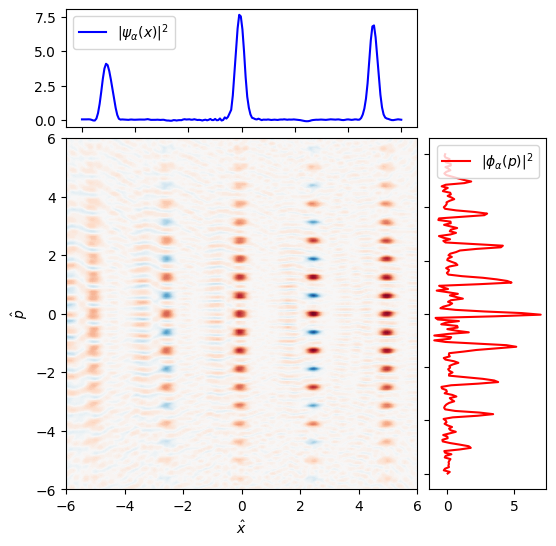

In [72]:
#This cell is mostly plotting
w = c2qa.wigner.wigner(stateop, axes_max= 6, axes_min= -6, axes_steps = 200)
x_dist, y_dist = margins(w.T)

fig = plt.figure(figsize=(6,6))
gs = fig.add_gridspec(2, 2,  width_ratios=(3, 1), height_ratios=(1, 3),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
ax = fig.add_subplot(gs[1,0])
ax_x = fig.add_subplot(gs[0,0])
ax_y = fig.add_subplot(gs[1,1])

absmax = max(np.max(w), np.abs(np.min(w)))
color_levels = np.linspace(-absmax, absmax, 100)

#Plot the wigner function of the state in the main panel with a colormap
xaxis = np.linspace(-6, 6, 200)
yaxis = np.linspace(-6, 6, 200)
cont = ax.contourf(xaxis, yaxis, w, color_levels, cmap = "RdBu_r")

#plot the distributions against the (normalized) marginals of the wigner function
ax_x.plot(xaxis, x_dist,  label = r"$|\psi_\alpha(x)|^2$", c= "b")

ax_y.plot(y_dist.T, yaxis, label = r"$|\phi_\alpha(p)|^2$", c = "r")

ax.set(xlabel=r"$\hat x$", ylabel=r"$\hat p$")
ax_x.legend()
ax_y.legend()
ax_x.set_xticklabels([]);
ax_y.set_yticklabels([]);

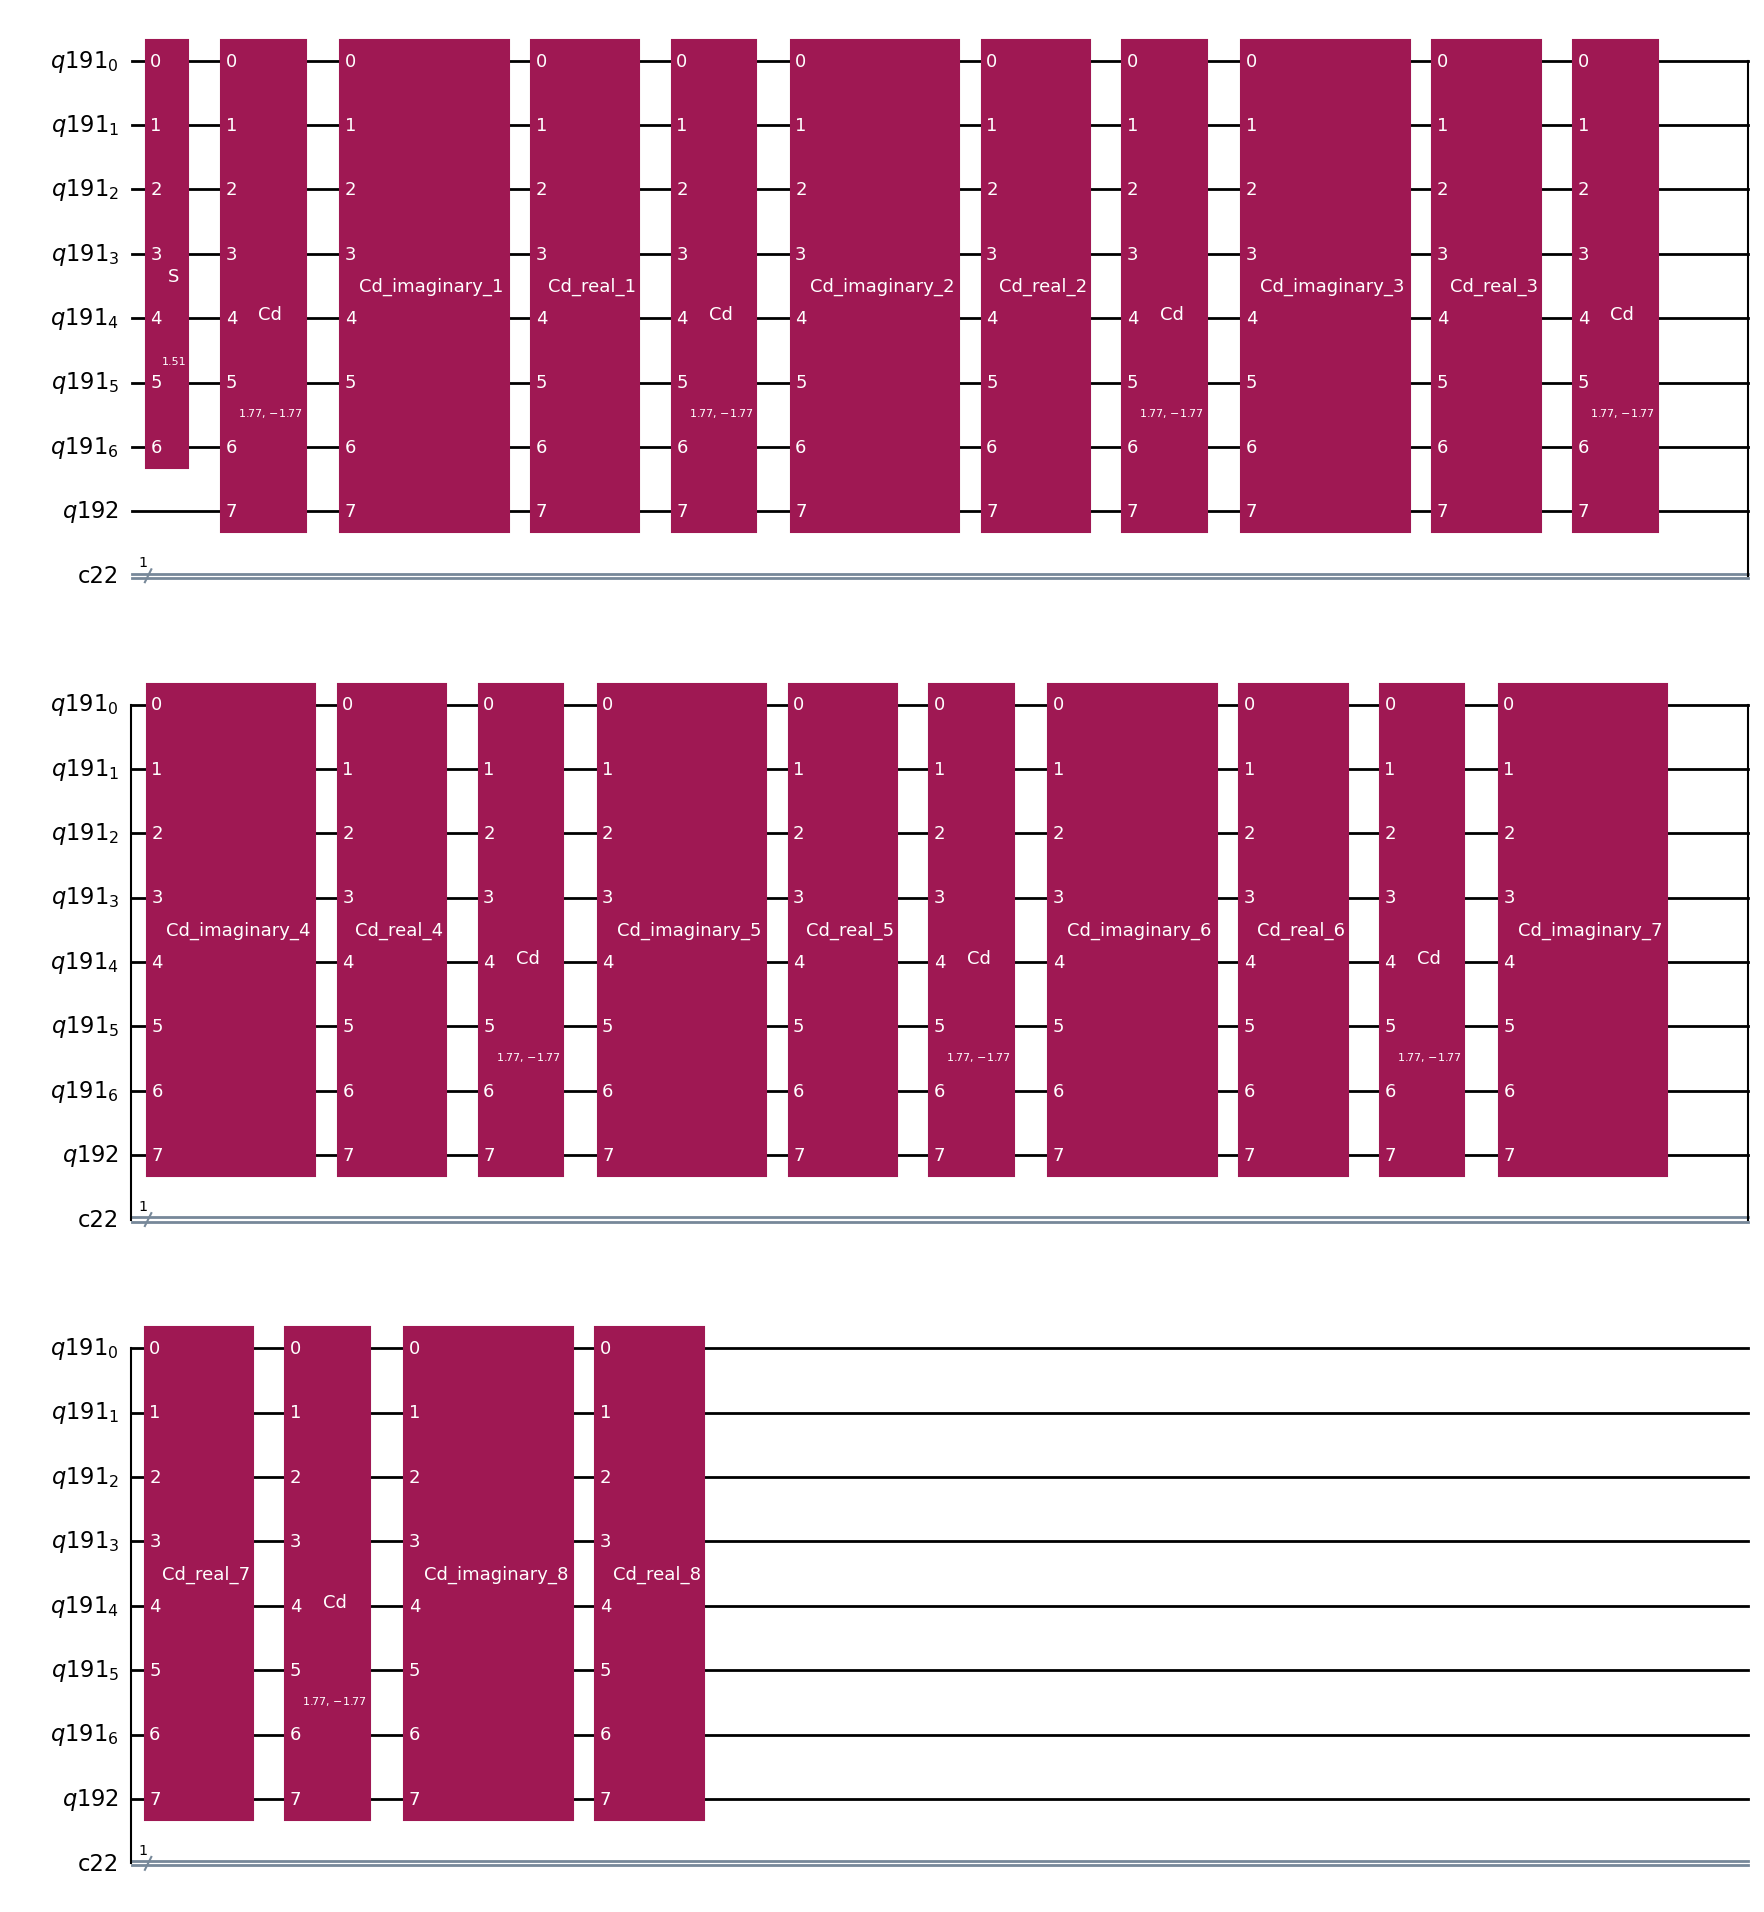

In [ ]:
# circuit.draw('mpl')